# BERT - Base Uncased for Customer Review Prediction

BERT (Bidirectional Encoder Representations from Transformers) Base Uncased (upper or lower case doesn't matter) is a pre-trained natural language processing model that can be fine-tuned on a custom dataset by adjusting its weights through backpropagation during training on domain-specific tasks, allowing it to learn and adapt to new linguistic patterns and contexts. This project will explore how the BERT model can be fit into the Yelp annual review dataset, and create a model that can predict a user rating based on the given review.

In [24]:
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
import time 
import pandas as pd
import numpy as np
from transformers import *
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import os
sns.set()

## Preparing the dataset

For testing purposes, only 150000 has been taken as a subset from the main dataset and a new dataframe is formed with the 'text' and 'stars' fields. Further on the classes are balanced and split into train, test and validation further in the code. The below cells have been crafted after performing extensive EDA on the Yelp reviews dataset which can be view at [https://github.com/yohanAbhishek/customer-review-prediction/blob/a8ee017620e1c0018731e56896b6a8cd9a5cb962/notebooks/eda/eda_m.ipynb

In [25]:
df = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=300000)

min_length = 100
max_length = 512

df = df.loc[(df['text'].str.len() > min_length) & (df['text'].str.len() <= max_length), ['text', 'stars']]

# Balance class counts in both training and test sets
class_counts = df['stars'].value_counts()
min_class_count = class_counts.min()

balanced_train_df = pd.concat([df[df['stars'] == star].sample(min_class_count, random_state=42) for star in class_counts.index])
test_df = pd.concat([df[df['stars'] == star].sample(min_class_count, random_state=42) for star in class_counts.index])

# Split the data into training and testing sets
train_df, _ = train_test_split(balanced_train_df, test_size=0.2, stratify=balanced_train_df['stars'], random_state=42)
test_df, _ = train_test_split(test_df, test_size=0.2, stratify=test_df['stars'], random_state=42)

# Reset the indices
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [26]:
train_df['stars'].value_counts()

stars
5    9073
2    9073
3    9073
1    9073
4    9072
Name: count, dtype: int64

In [27]:
test_df['stars'].value_counts()

stars
5    9073
2    9073
3    9073
1    9073
4    9072
Name: count, dtype: int64

In [28]:
def count_parameters(model):
    """Count the total number of trainable parameters in the PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
FINE_TUNE = True

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)  # Set num_labels to 5

# Modify the classifier head
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(model.config.hidden_size, 5))  # Use model.config.hidden_size

# Display total trainable parameters in the entire model
print(f'Total model trainable parameters: {count_parameters(model)}')

# Fine-tune the model
if FINE_TUNE:
    # Freeze BERT base parameters
    for param in model.bert.parameters():
        param.requires_grad = False

    # Allow training of classifier head parameters
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Display total trainable parameters in the classifier head
    print(f'Total head trainable parameters: {count_parameters(model)}')

# Move the model to GPU if available
model.cuda()

loading file vocab.txt from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading file tokenizer.json from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer.json
loading configuration file config.json from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointi

Total model trainable parameters: 109489930
Total head trainable parameters: 7690


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [7]:
model.classifier

Linear(
  in_features=768, out_features=5, bias=True
  (bert_activation): Tanh()
  (prediction): Linear(in_features=768, out_features=5, bias=True)
)

In [8]:
def generate_dataset(df, text_col, label_col):
    examples = [
        InputExample(guid=idx, text_a=row[text_col], label=row[label_col])
        for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Creating examples")
    ]

    features = glue_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        max_length=300,
        label_list=df[label_col].values,
        output_mode='regression'
    )

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label - 1 for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [9]:
train_dataset = generate_dataset(train_df, 'text', 'stars')
test_dataset = generate_dataset(test_df, 'text', 'stars')

Creating examples:   0%|          | 0/45364 [00:00<?, ?it/s]

/home/yohan/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
*** Example ***
guid: 0
features: InputFeatures(input_ids=[101, 1045, 2293, 2023, 7815, 4497, 999, 999, 2035, 1997, 1996, 29254, 2024, 6919, 1010, 1998, 1996, 2326, 2003, 2061, 16115, 3468, 1010, 2025, 2000, 5254, 2008, 25628, 6963, 1997, 7815, 2064, 2131, 3492, 6450, 1010, 2021, 2023, 7815, 16180, 1037, 2146, 2051, 1998, 2003, 1037, 6669, 6919, 3976, 1012, 1045, 1005, 2310, 2109, 1996, 7198, 9767, 2205, 1010, 1998, 2027, 2467, 2681, 2026, 3096, 3110, 5744, 1998, 19773, 6919, 2035, 2083, 1996, 2279, 2154, 1012, 1045, 2097, 2467, 36

Creating examples:   0%|          | 0/45364 [00:00<?, ?it/s]

*** Example ***
guid: 0
features: InputFeatures(input_ids=[101, 1045, 2293, 2023, 7815, 4497, 999, 999, 2035, 1997, 1996, 29254, 2024, 6919, 1010, 1998, 1996, 2326, 2003, 2061, 16115, 3468, 1010, 2025, 2000, 5254, 2008, 25628, 6963, 1997, 7815, 2064, 2131, 3492, 6450, 1010, 2021, 2023, 7815, 16180, 1037, 2146, 2051, 1998, 2003, 1037, 6669, 6919, 3976, 1012, 1045, 1005, 2310, 2109, 1996, 7198, 9767, 2205, 1010, 1998, 2027, 2467, 2681, 2026, 3096, 3110, 5744, 1998, 19773, 6919, 2035, 2083, 1996, 2279, 2154, 1012, 1045, 2097, 2467, 3604, 2000, 2358, 1012, 2798, 2000, 2490, 2023, 6919, 2449, 999, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [11]:
model(input_ids=train_dataset[:2][0].cuda(), 
      attention_mask=train_dataset[:2][1].cuda(), 
      labels=train_dataset[:2][2].cuda());

In [12]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

lr = 0.00002
optimizer = AdamW(model.classifier.parameters(), lr=lr)  

tr_losses = []
v_losses = []

/home/yohan/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from tqdm.notebook import tqdm as tqdm_notebook
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
import os
import numpy as np

# Set the maximum number of epochs
max_epochs = 75

# Set the early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
no_improvement_count = 0

# Assuming you have a function to calculate accuracy
def calculate_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    return accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())

criterion = CrossEntropyLoss()

for epoch in tqdm_notebook(range(max_epochs), desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    epoch_tr_accuracies = []  # To store training accuracies
    tr_accuracies = []


    print(f'epoch {epoch+1}')

    model.train()  # Set the model to training mode

    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda(),
                     'labels': labels.cuda()}

        optimizer.zero_grad()  # Zero the gradients

        # Assuming model returns a tuple (loss, pred)
        loss_tuple = model(**feed_dict)
        loss = loss_tuple[0]
        loss.backward()

        optimizer.step()

        epoch_tr_losses.append(loss.item())

        # Calculate accuracy and store it
        accuracy = calculate_accuracy(loss_tuple[1], labels)
        epoch_tr_accuracies.append(accuracy)

    tr_losses.append(np.mean(epoch_tr_losses))
    tr_accuracies.append(np.mean(epoch_tr_accuracies))
    print(f'Train loss: {np.mean(epoch_tr_losses):.4f}, accuracy: {np.mean(epoch_tr_accuracies):.4f}')

    """ Validation stage """
    epoch_v_losses = []
    epoch_v_accuracies = []  # To store validation accuracies
    v_accuracies = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda(),
                         'labels': labels.cuda()}

            # Assuming model returns a tuple (loss, pred)
            loss_tuple = model(**feed_dict)
            loss = loss_tuple[0]
            epoch_v_losses.append(loss.item())

            # Calculate accuracy and store it
            accuracy = calculate_accuracy(loss_tuple[1], labels)
            epoch_v_accuracies.append(accuracy)

        v_losses.append(np.mean(epoch_v_losses))
        v_accuracies.append(np.mean(epoch_v_accuracies))
    print(f'validation loss: {np.mean(epoch_v_losses):.4f}, accuracy: {np.mean(epoch_v_accuracies):.4f}')

    # Early stopping
    if np.mean(epoch_v_losses) < best_val_loss:
        best_val_loss = np.mean(epoch_v_losses)
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print(f'No improvement in validation loss for {early_stopping_patience} epochs. Early stopping...')
        break

    # Define the folder name
    folder_name = 'trained_epochs'
    
    # Create the folder if it doesn't exist
    folder_path = os.path.join(os.getcwd(), folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the model's state dictionary in the folder
    torch.save(model.classifier.state_dict(), os.path.join(folder_path, f'yelp-head{epoch}.pt'))

epoch:   0%|          | 0/75 [00:00<?, ?it/s]

epoch 1


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.5951, accuracy: 0.2491


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.5609, accuracy: 0.3003
epoch 2


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.5513, accuracy: 0.3169


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.5199, accuracy: 0.3673
epoch 3


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.5188, accuracy: 0.3509


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.4887, accuracy: 0.3798
epoch 4


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.4907, accuracy: 0.3701


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.4605, accuracy: 0.4054
epoch 5


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.4669, accuracy: 0.3842


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.4368, accuracy: 0.4180
epoch 6


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.4477, accuracy: 0.3920


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.4172, accuracy: 0.4203
epoch 7


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.4328, accuracy: 0.4024


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.4000, accuracy: 0.4310
epoch 8


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.4137, accuracy: 0.4086


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3875, accuracy: 0.4273
epoch 9


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.4036, accuracy: 0.4126


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3700, accuracy: 0.4442
epoch 10


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3898, accuracy: 0.4183


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3569, accuracy: 0.4502
epoch 11


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3760, accuracy: 0.4242


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3492, accuracy: 0.4451
epoch 12


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3671, accuracy: 0.4270


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3366, accuracy: 0.4510
epoch 13


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3578, accuracy: 0.4341


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3276, accuracy: 0.4469
epoch 14


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3490, accuracy: 0.4331


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3180, accuracy: 0.4569
epoch 15


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3416, accuracy: 0.4360


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3089, accuracy: 0.4610
epoch 16


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3318, accuracy: 0.4427


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.3051, accuracy: 0.4638
epoch 17


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3250, accuracy: 0.4431


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2939, accuracy: 0.4674
epoch 18


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3214, accuracy: 0.4452


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2891, accuracy: 0.4682
epoch 19


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3113, accuracy: 0.4495


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2817, accuracy: 0.4689
epoch 20


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3068, accuracy: 0.4523


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2770, accuracy: 0.4704
epoch 21


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.3027, accuracy: 0.4491


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2697, accuracy: 0.4735
epoch 22


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2978, accuracy: 0.4546


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2647, accuracy: 0.4713
epoch 23


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2931, accuracy: 0.4535


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2627, accuracy: 0.4768
epoch 24


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2873, accuracy: 0.4578


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2567, accuracy: 0.4740
epoch 25


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2845, accuracy: 0.4586


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2506, accuracy: 0.4773
epoch 26


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2789, accuracy: 0.4612


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2484, accuracy: 0.4785
epoch 27


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2760, accuracy: 0.4595


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2430, accuracy: 0.4792
epoch 28


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2726, accuracy: 0.4590


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2409, accuracy: 0.4819
epoch 29


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2700, accuracy: 0.4625


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2382, accuracy: 0.4767
epoch 30


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2662, accuracy: 0.4605


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2327, accuracy: 0.4855
epoch 31


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2615, accuracy: 0.4650


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2304, accuracy: 0.4834
epoch 32


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2594, accuracy: 0.4683


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2251, accuracy: 0.4897
epoch 33


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2566, accuracy: 0.4696


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2261, accuracy: 0.4847
epoch 34


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2535, accuracy: 0.4642


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2213, accuracy: 0.4900
epoch 35


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2511, accuracy: 0.4681


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2175, accuracy: 0.4911
epoch 36


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2497, accuracy: 0.4680


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2175, accuracy: 0.4867
epoch 37


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2471, accuracy: 0.4694


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2125, accuracy: 0.4896
epoch 38


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2458, accuracy: 0.4672


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2123, accuracy: 0.4907
epoch 39


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2421, accuracy: 0.4690


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2085, accuracy: 0.4916
epoch 40


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2392, accuracy: 0.4703


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2023, accuracy: 0.4905
epoch 41


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2365, accuracy: 0.4728


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2004, accuracy: 0.4957
epoch 42


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2360, accuracy: 0.4695


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.2000, accuracy: 0.4963
epoch 43


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2329, accuracy: 0.4742


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1978, accuracy: 0.4946
epoch 44


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2313, accuracy: 0.4753


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1957, accuracy: 0.4930
epoch 45


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2305, accuracy: 0.4755


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1936, accuracy: 0.4998
epoch 46


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2299, accuracy: 0.4738


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1946, accuracy: 0.4962
epoch 47


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2269, accuracy: 0.4740


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1934, accuracy: 0.4929
epoch 48


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2248, accuracy: 0.4749


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1905, accuracy: 0.5004
epoch 49


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2242, accuracy: 0.4766


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1870, accuracy: 0.5025
epoch 50


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2224, accuracy: 0.4763


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1847, accuracy: 0.4973
epoch 51


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2226, accuracy: 0.4776


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1850, accuracy: 0.5001
epoch 52


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2190, accuracy: 0.4769


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1811, accuracy: 0.4992
epoch 53


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2179, accuracy: 0.4793


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1800, accuracy: 0.4970
epoch 54


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2156, accuracy: 0.4787


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1764, accuracy: 0.5037
epoch 55


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2154, accuracy: 0.4782


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1783, accuracy: 0.5021
epoch 56


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2139, accuracy: 0.4783


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1742, accuracy: 0.5007
epoch 57


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2127, accuracy: 0.4774


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1746, accuracy: 0.5013
epoch 58


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2112, accuracy: 0.4817


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1736, accuracy: 0.5015
epoch 59


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2078, accuracy: 0.4810


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1760, accuracy: 0.5023
epoch 60


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2085, accuracy: 0.4810


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1693, accuracy: 0.5064
epoch 61


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2075, accuracy: 0.4822


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1668, accuracy: 0.5047
epoch 62


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2043, accuracy: 0.4836


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1725, accuracy: 0.5030
epoch 63


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2037, accuracy: 0.4839


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1693, accuracy: 0.5045
epoch 64


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2074, accuracy: 0.4822


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1657, accuracy: 0.5066
epoch 65


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2034, accuracy: 0.4833


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1646, accuracy: 0.5088
epoch 66


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1993, accuracy: 0.4841


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1634, accuracy: 0.5023
epoch 67


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.2030, accuracy: 0.4838


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1635, accuracy: 0.5045
epoch 68


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1978, accuracy: 0.4875


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1635, accuracy: 0.5092
epoch 69


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1996, accuracy: 0.4849


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1598, accuracy: 0.5078
epoch 70


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1991, accuracy: 0.4825


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1588, accuracy: 0.5079
epoch 71


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1962, accuracy: 0.4851


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1563, accuracy: 0.5099
epoch 72


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1975, accuracy: 0.4845


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1595, accuracy: 0.5036
epoch 73


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1972, accuracy: 0.4853


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1592, accuracy: 0.5075
epoch 74


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1961, accuracy: 0.4839


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1542, accuracy: 0.5088
epoch 75


batch:   0%|          | 0/2552 [00:00<?, ?it/s]

Train loss: 1.1950, accuracy: 0.4847


val batch:   0%|          | 0/142 [00:00<?, ?it/s]

validation loss: 1.1543, accuracy: 0.5106


Monitoring the convergence of the training x validation loss

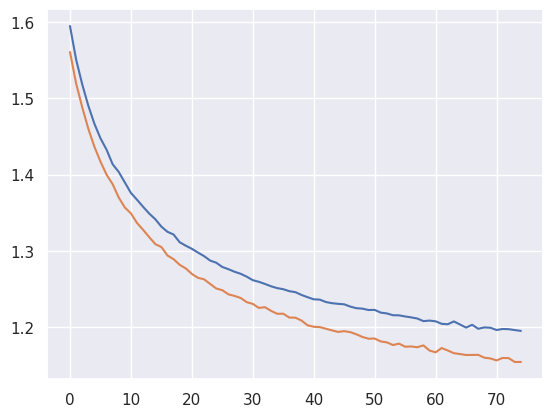

In [14]:
plt.plot(tr_losses)
plt.plot(v_losses)

In [15]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

val batch:   0%|          | 0/1418 [00:00<?, ?it/s]

In [16]:
predictions = np.array([i for k in batch_predictions for i in k ])

predictions = np.argmax(predictions, axis=1)
actual = np.array([i for k in batch_actual for i in k ])

In [17]:
from sklearn.metrics import f1_score, accuracy_score
accuracy = accuracy_score(actual, predictions)
accuracy

0.5142624107221585

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

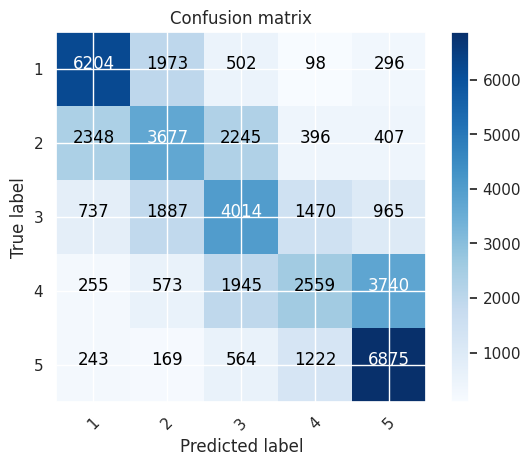

In [19]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(actual, predictions) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score, matthews_corrcoef

# Calculate additional evaluation metrics
precision = precision_score(actual, predictions, average='weighted')
recall = recall_score(actual, predictions, average='weighted')
f1 = f1_score(actual, predictions, average='weighted')
conf_matrix = confusion_matrix(actual, predictions)
mcc = matthews_corrcoef(actual, predictions)



# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'MCC: {mcc:.4f}')

Accuracy: 0.5143
Precision: 0.5032
Recall: 0.5143
F1 Score: 0.5017
Confusion Matrix:
[[6204 1973  502   98  296]
 [2348 3677 2245  396  407]
 [ 737 1887 4014 1470  965]
 [ 255  573 1945 2559 3740]
 [ 243  169  564 1222 6875]]
MCC: 0.3955


In [22]:
from sklearn.preprocessing import label_binarize

# Assuming model returns logits
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        logits = model(**feed_dict)[0].cpu()
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        
        batch_predictions.append(probabilities.numpy())
        batch_actual.append(labels)

val batch:   0%|          | 0/1418 [00:00<?, ?it/s]

NameError: name 'num_classes' is not defined

In [23]:
num_classes = 5
# Concatenate predictions and actual labels
predictions = np.vstack(batch_predictions)
actual_binarized = label_binarize(np.concatenate(batch_actual), classes=range(num_classes))

In [24]:
# Print shapes for debugging
print("Shape of actual_binarized:", actual_binarized.shape)
print("Shape of predictions:", predictions.shape)

Shape of actual_binarized: (136092, 5)
Shape of predictions: (136092, 5)


In [26]:
# Calculate ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(actual_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

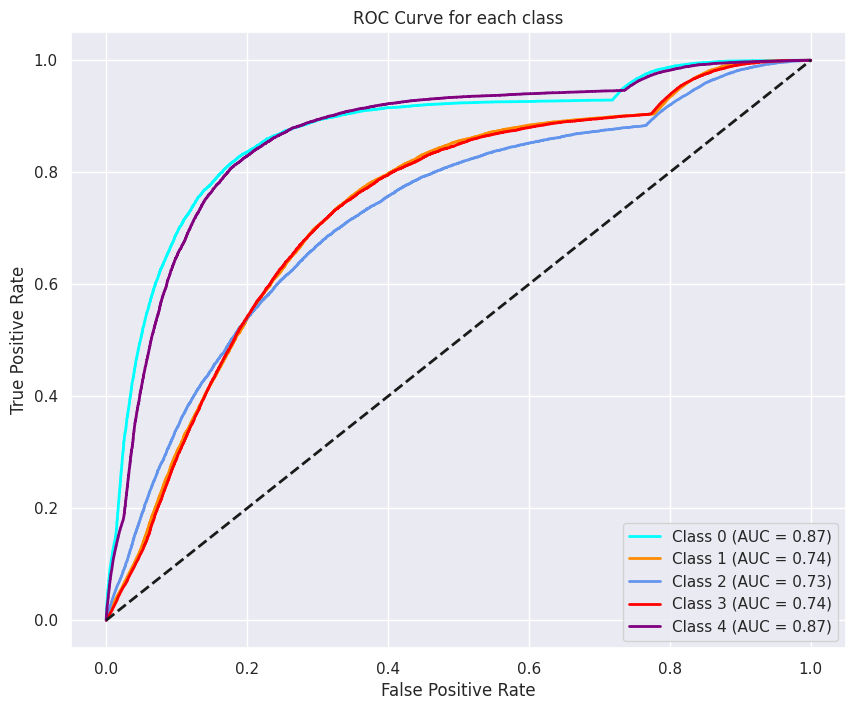

In [29]:
from itertools import cycle

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple'])  # Add more colors if needed

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()

In [31]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn

# Load the saved model state dictionary
saved_model_path = 'trained_epochs/yelp-head74.pt'
model_state_dict = torch.load(saved_model_path)

In [40]:
model.cuda()

# Tokenize the new text
text = '''
    This hotel is a gem. The service is top-notch, the rooms are beautifully decorated, and the location is perfect. 
    Every detail is taken care of to ensure a flawless experience. If you're looking for a five-star stay, this is the place to be.
'''
inputs = tokenizer(text, return_tensors="pt", max_length=300, truncation=True)

# Move input tensors to GPU
inputs = {key: value.cuda() for key, value in inputs.items()}

# Forward pass to get predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get the predicted class
predicted_class = torch.argmax(logits, dim=1).item()

print(f'Predicted Rating: {predicted_class + 1}')  # Adding 1 because your labels are in the range [1, 5]

Predicted Rating: 5
